In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

In [2]:
df = pd.read_csv('loans_full_schema.csv')  # your upload
print("Initial data:", df.shape)
print(df.columns.tolist())

Initial data: (10000, 56)
['Unnamed: 0', 'emp_title', 'emp_length', 'state', 'homeownership', 'annual_income', 'verified_income', 'debt_to_income', 'annual_income_joint', 'verification_income_joint', 'debt_to_income_joint', 'delinq_2y', 'months_since_last_delinq', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_accounts_delinq', 'total_collection_amount_ever', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_120d_past_due', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt', 'loan_purpose', 'application_type', 'loan_amount', 'term',

In [3]:
# Select relevant columns (from your data)
df = df[['loan_amount', 'term', 'interest_rate', 'annual_income', 'debt_to_income', 'loan_status']].dropna()
# Preprocess interest rate (if needed)
df['interest_rate'] = df['interest_rate'].astype(float)
df['term'] = df['term'].astype(int)

# Filter rows with known outcomes
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Define features and target
y = df['loan_status'].map({'Fully Paid': 0, 'Charged Off': 1})
X = df.drop('loan_status', axis=1)

In [4]:
print("Target distribution:\n", y.value_counts(normalize=True))

Target distribution:
 loan_status
0    0.984513
1    0.015487
Name: proportion, dtype: float64


In [18]:
from imblearn.over_sampling import SMOTE

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# count minority samples in the current training split
minority_count = y_train.value_counts()[1]
# choose k_neighbors so it's always less than minority_count
k = min(5, minority_count - 1)

sm = SMOTE(random_state=42, k_neighbors=k, sampling_strategy=0.5)
X_res, y_res = sm.fit_resample(X_train, y_train)
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced' , random_state=42)
model.fit(X_res, y_res)

# Predict
y_proba = model.predict_proba(X_val)[:, 1]
y_pred = (y_proba >= 0.45).astype(int)  # Try lowering threshold from 0.5 to 0.4

# Evaluate
print("Classification Report:\n", classification_report(y_val, y_pred))
print("ROC AUC Score:", roc_auc_score(y_val, y_proba))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99        90
           1       0.33      1.00      0.50         1

    accuracy                           0.98        91
   macro avg       0.67      0.99      0.74        91
weighted avg       0.99      0.98      0.98        91

ROC AUC Score: 0.9777777777777777
Confusion Matrix:
 [[88  2]
 [ 0  1]]


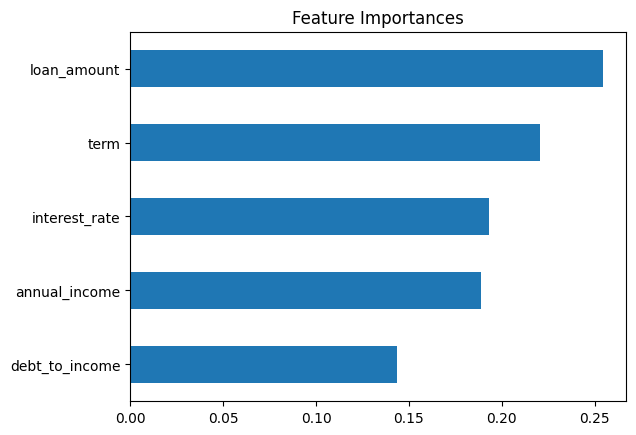

In [7]:
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Feature Importances')
plt.show()